In [10]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import svd

# load png image as numpy matrix at given user path
def load_image(path):
    from PIL import Image
    img = Image.open(path)
    img.load()
    data = np.asarray(img, dtype="float32")
    return data
    
# smoothstep function
def smoothstep(min, max, x):
    if x < min:
        return 0.0
    if x > max:
        return 1.0
    x = (x - min) / (max - min)
    return x * x * (3 - 2 * x)


def SVD_Decomposition(matrix, num_ranks, N, Nc, normalize = False, symmetric = False):
    # normalize the matrix
    if normalize:
        matrix = matrix / np.sum(matrix)

    # calculate the SVD decomposition
    U, s, V = svd(matrix)
        
    #also write the glsl code to a file and clear the file first
    with open("kernels.glsl", "w") as f:
        f.write("//The first {} columns of the U matrix: \n".format(num_ranks))

        if not symmetric:
            f.write("float U[{}] = float[](".format(N * num_ranks))
            array = ""
            for i in range(num_ranks-1):
                for j in range(N):
                    array += "{:.4E}, ".format(U[j, i])
            for j in range(N-1):
                array += "{:.4E}, ".format(U[j, num_ranks-1])
            array += "{:.4E}".format(U[N-1, num_ranks-1])
            f.write(array)
            f.write("); \n")

            f.write("//The first {} rows of the V matrix: \n".format(num_ranks))
            f.write("float V[{}] = float[](".format(N * num_ranks))
            array = ""
            for i in range(num_ranks-1):
                for j in range(N):
                    array += "{:.4E}, ".format(V[i, j] * s[i])
            for j in range(N-1):
                array += "{:.4E}, ".format(V[num_ranks-1, j] * s[num_ranks-1])
            array += "{:.4E}".format(V[num_ranks-1, N-1] * s[num_ranks-1])
            f.write(array)
            f.write("); \n")
            f.write("//center of the convolution \n")
            f.write("int Nc = {}; \n".format(Nc))
            f.write("//number of ranks \n")
            f.write("int Nr = {}; \n".format(num_ranks))
            f.write("//convolution size \n")
            f.write("int N = {}; \n".format(N))
        else:
            f.write("//center of the convolution \n")
            f.write("const int Nc = {}; \n".format(Nc))
            f.write("//number of ranks \n")
            f.write("const int Nr = {}; \n".format(num_ranks))
            f.write("//convolution size \n")
            f.write("const int N = {}; \n".format(N))
            if symmetric:
                f.write("//symmetric convolution \n")
                f.write("#define SYMMETRIC")
    
    # reconstruct the matrix using 2 first ranks
    matrix_reconstructed = np.zeros((N, N))
    for i in range(num_ranks):
        matrix_reconstructed += s[i] * np.outer(U[:, i], V[i, :])

    # compute the average of the matrix
    avg = np.sum(matrix) / (N * N)

    # plot the original and reconstructed matrices in log scale
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(np.log10(matrix + 1e-10*avg), cmap="gray")
    axs[0].set_title("Original matrix")
    axs[1].imshow(np.log10(matrix_reconstructed+ 1e-10*avg), cmap="gray")
    axs[1].set_title("Reconstructed matrix (using {} ranks)".format(num_ranks))
    plt.show()

    #compute the % error between the original and reconstructed matrix
    error = np.sum(np.abs(matrix - matrix_reconstructed)) / np.sum(matrix)
    print("Error: {:.5f}%".format(error * 100))

    #return the reconstructed matrix
    return matrix_reconstructed


In [10]:
matrix = img = load_image("C:/Users/micha/Downloads/basic-eye-kernel.png") 
matrix = matrix[:,:,0]

#make the matrix square
N = max(matrix.shape)
matrix = np.pad(matrix, ((0, N - matrix.shape[0]), (0, N - matrix.shape[1])), 'constant', constant_values=0)

matrix = matrix ** 2
matrix = matrix / np.sum(matrix)
N = matrix.shape[0]
Nc = N//2


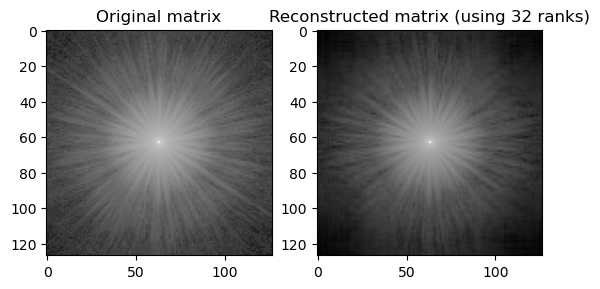

In [14]:
SVD_Decomposition(matrix, 32, N, Nc)

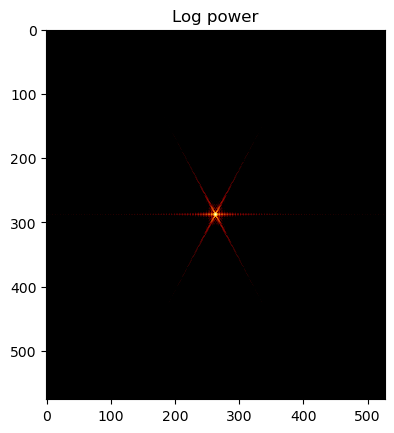

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

img = load_image("C:/Users/micha/Downloads/basic-eye-kernel.png.png") 
img = img[:, :527, :3].sum(axis=2) / 3. > 0.5
ft = np.fft.fftshift(np.fft.fft2(img))

p = np.abs(ft)**2
log_power = np.log10(p/p.max()) # log power

#plot log power
plt.imshow(log_power, cmap="afmhot", vmin=-6)
plt.title("Log power")
plt.show()

(264, 263)


C:\Users\micha\AppData\Local\Temp\ipykernel_14456\411119349.py:72: RuntimeWarning: invalid value encountered in log10
  axs[1].imshow(np.log10(matrix_reconstructed), cmap="gray")


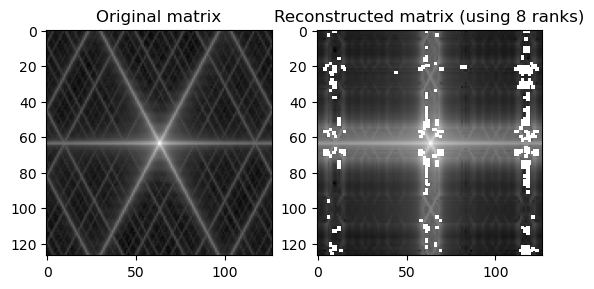

In [77]:
#make it square
size = p.shape
N = min(size)

if size[0] >= size[1]:
    pad = (size[0] - size[1]) // 2
    pow = p[pad:(size[0] - pad - 1), :]
else:
    pad = (size[1] - size[0]) // 2
    pow = p[:, pad:(size[1] - pad - 1)]


M = 127

#resample the N*N spectrum into a M*M matrix
pow = gaussian_filter(pow, 0.75)
#interpolate the spectrum to a M*M matrix
powI = np.zeros((M, M))

def Bilinear(array, x, y):
    x1 = int(x)
    x2 = x1 + 1
    y1 = int(y)
    y2 = y1 + 1
    a = x - x1
    b = y - y1
    return (1 - a) * (1 - b) * array[x1, y1] + a * (1 - b) * array[x2, y1] + (1 - a) * b * array[x1, y2] + a * b * array[x2, y2]

#bi-linear interpolation
for i in range(M):
    for j in range(M):
        powI[i, j] = Bilinear(pow, i * N / M, j * N / M)

#find the center coordinate (with max power)
centerPos = np.unravel_index(np.argmax(pow), pow.shape)

print(centerPos)

#pow = pow**2
SVD_Decomposition(powI, 8, powI.shape[0], powI.shape[0]//2)

In [46]:
p.shape

(576, 527)

In [50]:
pow.shape

(527, 527)

0.25000000000000006
0.24999999999999994
0.25
0.25
0.25000000000000006
0.25
0.2500000000000004
0.25
0.25000000000000006
0.2500000000000002
0.25000000000000017
0.24999999999999994
0.2499999999999997
0.25000000000000017
0.2500000000000003
0.24999999999999914
0.24999999999999825
0.24999999999998887
0.24999999999994466
0.24999999999977524
0.24999999999920575
0.24999999999750716
0.24999999999292621
0.24999999998162034
0.24999999995580355
0.24999999990074168
0.24999999979019524
0.24999999957986074
0.2499999991983888
0.24999999853562824
0.2499999974277962
0.24999999563947214
0.24999999284238306
0.2499999885911823
0.2499999822965153
0.24999997319585504
0.24999996032266458
0.24999994247454674
0.24999991818112813
0.24999988567234954
0.24999984284795065
0.2499997872487727
0.24999971603055626
0.2499996259407201
0.24999951329862563
0.24999937397964378
0.2499992034032838
0.24999899652557014
0.24999874783567372
0.24999845135682347
0.24999810065135716
0.2499976888297687
0.2499972085635101
0.24999665210

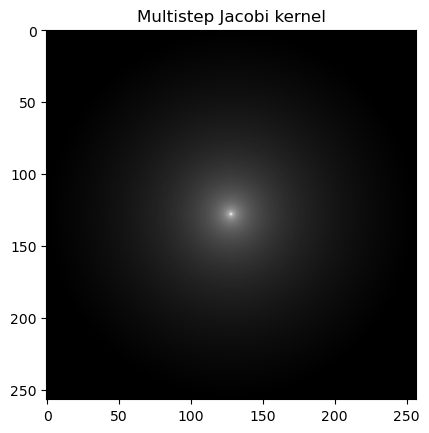

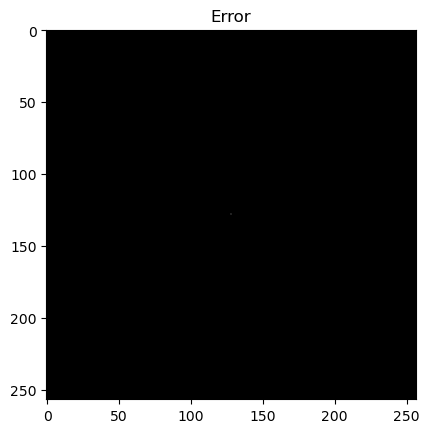

7.376097907108835e-05
0.22637216870001567
0.0005090460785047118


In [14]:
# multistep poisson equation kernel
multistep_jacobi = np.zeros((257, 257))

average_kernel = np.array([[0, 0.25, 0], [0.25, 0, 0.25], [0, 0.25, 0]])

#get the size of the array
new_size = multistep_jacobi.shape[0]

center = new_size // 2

#do a red black gauss seidel iteration using numpy    
#array of coordinates
xcoord = np.arange(new_size)
ycoord = np.arange(new_size)

coordsx, coordsy = np.meshgrid(xcoord, ycoord)

#array of red and black coordinates
red = (coordsx + coordsy) % 2 == 0
black = 1 - red

dist_to_center = np.sqrt((coordsx - center)**2 + (coordsy - center)**2)

#boundary mask at distance new_size/2
boundary_mask = dist_to_center < new_size / 2

def averageFilter(array):
    #use scipy convolve2d to average the array
    import scipy.signal
    return scipy.signal.convolve2d(array, average_kernel, mode='same')
    

#solve the possion equation for a delta function source at the center for 1 step
def poissonConv(a):
    a = averageFilter(a)

    #add the source
    a[center, center] += 0.25

    #zero border conditions
    a = a * boundary_mask

    return a


# check the error of the poisson equation
def poissonError(a):
    #get the size of the array
    new_size = a.shape[0]

    center = new_size // 2
    error = averageFilter(a) - a.copy()

    #add the source
    error[center, center] += 0.25

    #zero border conditions
    a = a * boundary_mask

    return np.abs(error)

# convolve the multistep kernel with the poisson kernel N times
for i in range(1000):
    for j in range(32):
        multistep_jacobi = poissonConv(multistep_jacobi)
    error = poissonError(multistep_jacobi)
    print(np.sum(error))

# plot the result
plt.imshow(multistep_jacobi, cmap="gray")
plt.title("Multistep Jacobi kernel")
plt.clim(np.min(multistep_jacobi), np.max(multistep_jacobi))
plt.show()

# plot the error
error = poissonError(multistep_jacobi)
plt.imshow(poissonError(error), cmap="gray")
plt.title("Error")
#use the same color scale as the multistep kernel
plt.clim(np.min(multistep_jacobi), np.max(multistep_jacobi))
plt.show()

print(np.sum(error**2))
print(np.sum(error))
#print max error
print(np.max(error))

def poisson_direct(a, boundary):
    new_size = a.shape[0]
    center = new_size // 2
    A = np.zeros(shape=(new_size,new_size,new_size,new_size),dtype='d')
    b = np.zeros(shape=(new_size,new_size),dtype='d')
    
    # discretized differential operator
    for i in range(1,new_size-1):
        for j in range(1,new_size-1):
            if(boundary[i,j] == 0):
                 A[i,j,i,j] = 1
            else:
                A[i,j,i-1,j] = A[i,j,i+1,j] = A[i,j,i,j-1] = A[i,j,i,j+1] = 1
                A[i,j,i,j] = -4
    
    #boundary conditions
    for i in range(new_size):
        A[i,0,i,0] = A[i,-1,i,-1] = A[0,i,0,i] = A[-1,i,-1,i] = 1

    # source term
    b[center,center] = -1.0
    
    x = np.linalg.tensorsolve(A,b)

    #test error,tensor multiply A with x and subtract b
    #error = np.tensordot(A,x,axes=([0,1],[0,1])) - b
    #print(np.sum(error**2))
    #print(np.sum(np.abs(error)))

    return x

#print("Direct Poisson")
#
#direct_poisson = poisson_direct(multistep_jacobi, boundary_mask)
#
#plt.imshow(direct_poisson, cmap="gray")
#plt.title("Direct Poisson")
#plt.clim(np.min(direct_poisson), np.max(direct_poisson))
#plt.show()
#
#error = poissonError(direct_poisson)
#plt.imshow(poissonError(error), cmap="gray")
#plt.title("Error")
##use the same color scale as the multistep kernel
#plt.clim(np.min(direct_poisson), np.max(direct_poisson))
#plt.show()
#
#print(np.sum(error**2))
#print(np.sum(error))
##print max error
#print(np.max(error))



In [ ]:
# check the error of the poisson equation
def poissonError(a):
    #get the size of the array
    new_size = a.shape[0]

    center = new_size // 2
    error = averageFilter(a) - a.copy()

    #add the source
    error[center, center] -= 0.25

    #zero border conditions
    a = a * boundary_mask

    return np.abs(error)

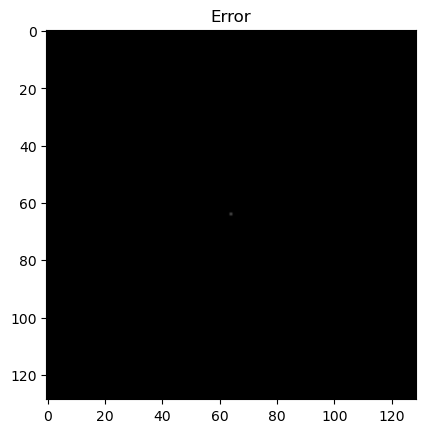

0.00019242153511412298
0.2500000000002305
0.0011259551490318469


In [237]:
error = poissonError(direct_poisson)
plt.imshow(poissonError(error), cmap="gray")
plt.title("Error")
#use the same color scale as the multistep kernel
plt.clim(np.min(direct_poisson), np.max(direct_poisson))
plt.show()

print(np.sum(error**2))
print(np.sum(error))
#print max error
print(np.max(error))

C:\Users\micha\AppData\Local\Temp\ipykernel_28404\1511573310.py:87: RuntimeWarning: invalid value encountered in log10
  axs[1].imshow(np.log10(matrix_reconstructed+ 1e-10*avg), cmap="gray")


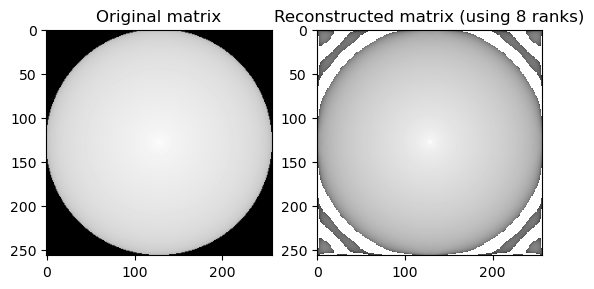

Error: 0.33142%


array([[1.73892280e-05, 2.68552594e-05, 2.30669683e-05, ...,
        2.30669683e-05, 2.68552594e-05, 1.73892280e-05],
       [2.68552594e-05, 5.83051769e-05, 7.26678821e-05, ...,
        7.26678821e-05, 5.83051769e-05, 2.68552594e-05],
       [2.30669683e-05, 7.26678821e-05, 1.14956369e-04, ...,
        1.14956369e-04, 7.26678821e-05, 2.30669683e-05],
       ...,
       [2.30669683e-05, 7.26678821e-05, 1.14956369e-04, ...,
        1.14956369e-04, 7.26678821e-05, 2.30669683e-05],
       [2.68552594e-05, 5.83051769e-05, 7.26678821e-05, ...,
        7.26678821e-05, 5.83051769e-05, 2.68552594e-05],
       [1.73892280e-05, 2.68552594e-05, 2.30669683e-05, ...,
        2.30669683e-05, 2.68552594e-05, 1.73892280e-05]])

In [15]:
# do SVD decomposition on the multistep kernel
SVD_Decomposition(multistep_jacobi, 8, multistep_jacobi.shape[0], multistep_jacobi.shape[0]//2, False, False)

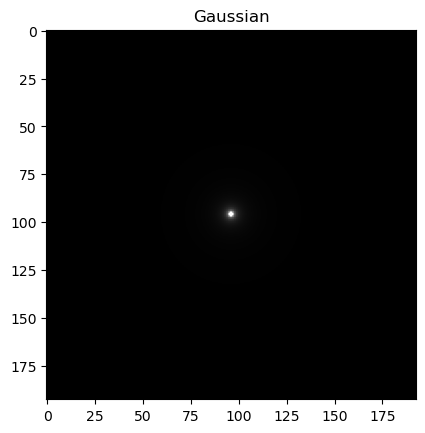

(96, 96)


In [252]:
# define the N*N matrix with a Gaussian in it
N = 2*96 + 1
Nc = N // 2
matrix = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        R = np.sqrt((i - Nc) ** 2 + (j - Nc) ** 2)
        # gaussian line in x direction
        xspike = 0. * np.exp(-((i - Nc) / 10.0) ** 2)
        # gaussian line in y direction
        yspike = 0. * np.exp(-((j - Nc) / 10.0) ** 2)
        kernel = xspike + yspike + (R**1.5 + 0.1)**(-1) 
        matrix[i, j] = kernel

# normalize the matrix, so that the sum of all elements is 1
matrix /= np.sum(matrix)

# plot the matrix
plt.imshow(matrix, cmap="gray")
plt.title("Gaussian")
plt.clim(np.min(matrix), 0.1*np.max(matrix))
plt.show()

#print the coordinate of the maximum value
print(np.unravel_index(np.argmax(matrix), matrix.shape))

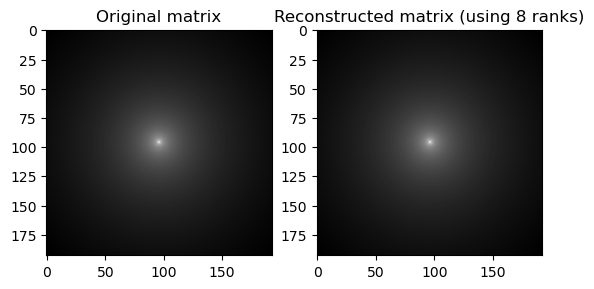

Error: 0.10853%


array([[4.78853840e-06, 4.83003588e-06, 4.87189988e-06, ...,
        4.87189988e-06, 4.83003588e-06, 4.78853840e-06],
       [4.83003588e-06, 4.87208886e-06, 4.91451954e-06, ...,
        4.91451954e-06, 4.87208886e-06, 4.83003588e-06],
       [4.87189988e-06, 4.91451954e-06, 4.95752842e-06, ...,
        4.95752842e-06, 4.91451954e-06, 4.87189988e-06],
       ...,
       [4.87189988e-06, 4.91451954e-06, 4.95752842e-06, ...,
        4.95752842e-06, 4.91451954e-06, 4.87189988e-06],
       [4.83003588e-06, 4.87208886e-06, 4.91451954e-06, ...,
        4.91451954e-06, 4.87208886e-06, 4.83003588e-06],
       [4.78853840e-06, 4.83003588e-06, 4.87189988e-06, ...,
        4.87189988e-06, 4.83003588e-06, 4.78853840e-06]])

In [253]:
SVD_Decomposition(matrix, 8, matrix.shape[0], matrix.shape[0]//2)